In [1]:
import numpy as np
import pandas as pd
from random import seed
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error



In [2]:
class DataLoader:

  def __init__(self, dataPath):
      self.dataPath = dataPath
      print("load dataset")
      self.load_data = pd.read_csv(self.dataPath)

  def clean_data(self, load_data):
      print("clean dataset")
      load_data = load_data.dropna()
      load_data = load_data.drop_duplicates()
      return load_data

  def standardize_scale_data(self, load_data):
      print("dataset standardize and scale")
      scaler = MinMaxScaler()
      load_data = load_data.iloc[:,[5]]
      process_data = pd.DataFrame(scaler.fit_transform(load_data))
      return process_data

  def processs_data(self):
      print("dataset process")
      cleaned_data = self.clean_data(self.load_data)
      standardized_data = self.standardize_scale_data(cleaned_data)
      return standardized_data

In [3]:
class Model:

    def train_initialize(self, data_loader, time_step):
        self.data_loader = data_loader
        self.time_step = time_step
        self.inputDimension = 1
        self.outputForecast = 1
        self.lr = float(input("Learning Rate:"))
        self.epochs = int(input("Iterations:"))
        self.hiddenLayer = int(input("Hidden layers:"))

        print("Model Initialization")
        print(f"Number of iterations: {self.epochs}")
        print(f"Learning rate: {self.lr}")
        print(f"Number of hidden layers: {self.hiddenLayer}")

        M, N = self.splitIntoDataSet(self.data_loader.processs_data())
        ratio = 0.8
        weights = 0.5
        multiplier = 0.1

        #splitting data in train and test
        self.X_trainData,self.X_testData,self.y_trainData, self.y_testData = self.dataSplit(M, N, ratio)
        self.intializeWeights(weights,multiplier)
        self.intializeBias(multiplier)
        self.initializeGates()


    def intializeWeights(self, weights, multiplier):
        dimensions = (self.hiddenLayer, self.inputDimension+self.hiddenLayer)
        self.forget_weight, self.ip_weight, self.outputWeight, self.activation_weight = [
            np.random.rand(*dimensions)*multiplier + weights for _ in range(4)
        ]
        self.finalWeight = np.random.rand(1, self.hiddenLayer)*multiplier + weights

    def intializeBias(self, multiplier):
        dimensions = (self.hiddenLayer, 1)
        self.forgetBias, self.inputBias, self.outputBias, self.activationBias = [
            np.random.rand(*dimensions)*multiplier for _ in range(4)
        ]
        self.finalBias = np.random.rand(1, 1)*0.1


    def initializeGates(self):
        dimensions = (self.hiddenLayer, self.inputDimension)

        gates = [np.zeros(dimensions)] * self.time_step * 5
        forwardOutput = [np.repeat(0, self.hiddenLayer).reshape(-1, 1)] * self.time_step

        self.st, self.activationGate, self.inputGate, self.forgetGate, self.outputGate = [gates[i*self.time_step:(i+1)*self.time_step] for i in range(5)]
        self.forwardOutput = forwardOutput

    def splitIntoDataSet(self, data):
        lengt = len(data) - self.time_step - self.outputForecast
        M = [data.iloc[i:i+self.time_step] for i in range(lengt)]
        N = [data.iloc[i+self.time_step+self.outputForecast] for i in range(lengt)]
        return np.array(M), np.array(N)

    def dataSplit(self, m, n, ratio):
        partition_in = int(m.shape[0] * ratio)
        M_trainData, M_testData = np.split(m, [partition_in])
        N_trainData, N_testData = np.split(n, [partition_in])
        return M_trainData,M_testData,N_trainData,N_testData

    def fit(self):
      ypredictions = []
      for e in range(self.epochs):
          c_loss = 0
          for ndx, train_data in enumerate(self.X_trainData):
              predicted_val = self.train_forward(train_data)
              self.train_backpropagate(self.y_trainData[ndx], predicted_val, train_data)
              c_loss += (self.y_trainData[ndx] - predicted_val) ** 2
          print(f"Epoch: {e}, Loss: {c_loss / len(self.X_trainData)}")

    def train_forward(self, data):
      gat = ['forwardOutput', 'forgetGate', 'inputGate', 'outputGate', 'activationGate', 'st']
      gat_v = []

      for _ in gat:
          gate_l = []
          for _ in range(self.time_step):
              gate_l.append(np.full((self.hiddenLayer, 1), 0))
          gat_v.append(gate_l)

      forwardOutput, forgetGate, inputGate, outputGate, activationGate, st = gat_v

      #forward
      for index in range(1,len(data)):
        trainingData = data[index]
        vstack=np.vstack((forwardOutput[index-1],trainingData))
        inputGate[index] = self.sigmoid(self.dotProduct(self.ip_weight,vstack)+self.inputBias)
        forgetGate[index] = self.sigmoid(self.dotProduct(self.forget_weight,vstack)+self.forgetBias)
        outputGate[index] = self.sigmoid(self.dotProduct(self.outputWeight,vstack)+self.outputBias)
        activationGate[index] = self.tan(self.dotProduct(self.activation_weight ,vstack) + self.activationBias)
        st[index] = (activationGate[index] * inputGate[index]) + (forgetGate[index] * st[index - 1])
        forwardOutput[index] = self.tan(st[index]) * outputGate[index]

      self.inputGate,self.forgetGate,self.forwardOutput,self.outputGate,self.activationGate,self.st=inputGate,forgetGate,forwardOutput,outputGate,activationGate,st
      output=self.dotProduct(self.finalWeight,self.forwardOutput[-1])+self.finalBias
      return output

    def train_backpropagate(self, yExpected, yPredicted, data):
        self.declareWeightDiff()
        self.declareBiasDiff()
        backwardOutput, stDiff = [[np.repeat(0, self.hiddenLayer).reshape(-1, 1) for i in range(self.time_step+1)] for j in range(2)]

        dOutput = yExpected - yPredicted
        self.finalWeightDiff, self.finalBiasDiff = dOutput * self.forwardOutput[-1].T, dOutput

        for index in reversed(range(self.time_step)):
            backwardOutput[index] = self.dotProduct(self.finalWeightDiff.T , dOutput) + backwardOutput[index+1]
            outputDiff = self.tan(self.st[index]) * backwardOutput[index] * (self.forwardOutput[index] * (1-self.forwardOutput[index]))
            stDiff[index] = self.outputGate[index] * backwardOutput[index] * ((1-self.st[index])* self.st[index]) + stDiff[index+1]

            inputDiff = self.activationGate[index] * stDiff[index] *((self.inputGate[index])*(1-self.inputGate[index]))
            forgetDiff = self.st[index-1] * stDiff[index] * (self.forgetGate[index]*(1-self.forgetGate[index]))

            vstack = np.vstack((self.forwardOutput[index-1], data[index]))

            self.forget_weightDiff, self.forgetBiasDiff = self.forget_weightDiff + self.dotProduct(forgetDiff,vstack.T), self.forgetBiasDiff + forgetDiff
            self.input_weightDiff, self.inputBiasDiff = self.input_weightDiff + self.dotProduct(inputDiff,vstack.T), self.inputBiasDiff + inputDiff
            self.outputWeightDiff, self.outputBiasDiff = self.outputWeightDiff + self.dotProduct(outputDiff,vstack.T), self.outputBiasDiff + outputDiff
            self.stWeightDiff, self.stBiasDiff = self.stWeightDiff + self.dotProduct(stDiff[index],vstack.T), self.stBiasDiff + stDiff[index]

        self.updateWeights()
        self.updateBias()


    def updateWeights(self):
        diffs = [self.stWeightDiff, self.input_weightDiff, self.outputWeightDiff, self.forget_weightDiff, self.finalWeightDiff]
        weights = [self.activation_weight, self.ip_weight, self.outputWeight, self.forget_weight, self.finalWeight]
        self.activation_weight, self.ip_weight, self.outputWeight, self.forget_weight, self.finalWeight = self.update_parameters(diffs, weights)

    def updateBias(self):
        diffs = [self.stBiasDiff, self.inputBiasDiff, self.outputBiasDiff, self.forgetBiasDiff, self.finalBiasDiff]
        biases = [self.activationBias, self.inputBias, self.outputBias, self.forgetBias, self.finalBias]
        self.activationBias, self.inputBias, self.outputBias, self.forgetBias, self.finalBias = self.update_parameters(diffs, biases)

    def declareWeightDiff(self):
        shapes = [(self.hiddenLayer, self.inputDimension+self.hiddenLayer)] * 5
        self.finalWeightDiff, self.forget_weightDiff, self.input_weightDiff, self.outputWeightDiff, self.stWeightDiff = self.declare_diffs(shapes)

    def declareBiasDiff(self):
        shapes = [(self.hiddenLayer, 1)] * 5
        self.finalBiasDiff, self.forgetBiasDiff, self.inputBiasDiff, self.outputBiasDiff, self.stBiasDiff = self.declare_diffs(shapes)

    def update_parameters(self, diffs, parameters):
        return [parameter + self.lr * (diff / self.time_step) for diff, parameter in zip(diffs, parameters)]

    def declare_diffs(self, shapes):
        return [np.zeros(shape) for shape in shapes]

    def predict(self):
        yPred = [self.train_forward(x_test) for x_test in self.X_testData]
        print(f'yPred: {yPred}')
        print(f'R2 Score: {r2_score(self.y_testData, np.concatenate(yPred))}')
        print(f'RMSE Score: {np.sqrt(mean_squared_error(self.y_testData, np.concatenate(yPred)))}')
        print(f'MSE Score: {mean_squared_error(self.y_testData, np.concatenate(yPred))}')
        self.graphPlot(self.y_testData, np.concatenate(yPred))


    sigmoid = lambda self, data: 1 / (1 + np.exp(-data))
    dotProduct = lambda self, x, y: np.dot(x, y)
    tan = lambda self, data: np.tanh(data)


    def graphPlot(self, x,y):
      plt.figure(figsize=(14, 7))
      plt.plot(x, color='midnightblue', label='Actual Closing Price')
      plt.plot(y, color='darkorange', linestyle='dashed', label='Predicted Closing Price')
      plt.title('Comparison of Actual and Predicted Closing Prices for AMZN', fontsize=16)
      plt.xlabel('Time', fontsize=14)
      plt.ylabel('Closing Price', fontsize=14)
      plt.grid(True)
      plt.legend(fontsize=12)
      plt.show()



Recurrent Neural Network Start
load dataset
Learning Rate:0.1
Iterations:150
Hidden layers:6
Model Initialization
Number of iterations: 150
Learning rate: 0.1
Number of hidden layers: 6
dataset process
clean dataset
dataset standardize and scale
Training the Model 
Epoch: 0, Loss: [[2.95828431e-05]]
Epoch: 1, Loss: [[3.32040513e-05]]
Epoch: 2, Loss: [[3.28402406e-05]]
Epoch: 3, Loss: [[3.24811608e-05]]
Epoch: 4, Loss: [[3.21267495e-05]]
Epoch: 5, Loss: [[3.17769448e-05]]
Epoch: 6, Loss: [[3.14316859e-05]]
Epoch: 7, Loss: [[3.10909126e-05]]
Epoch: 8, Loss: [[3.07545658e-05]]
Epoch: 9, Loss: [[3.04225868e-05]]
Epoch: 10, Loss: [[3.00949179e-05]]
Epoch: 11, Loss: [[2.97715023e-05]]
Epoch: 12, Loss: [[2.94522836e-05]]
Epoch: 13, Loss: [[2.91372065e-05]]
Epoch: 14, Loss: [[2.88262162e-05]]
Epoch: 15, Loss: [[2.85192588e-05]]
Epoch: 16, Loss: [[2.82162809e-05]]
Epoch: 17, Loss: [[2.79172301e-05]]
Epoch: 18, Loss: [[2.76220545e-05]]
Epoch: 19, Loss: [[2.73307028e-05]]
Epoch: 20, Loss: [[2.704

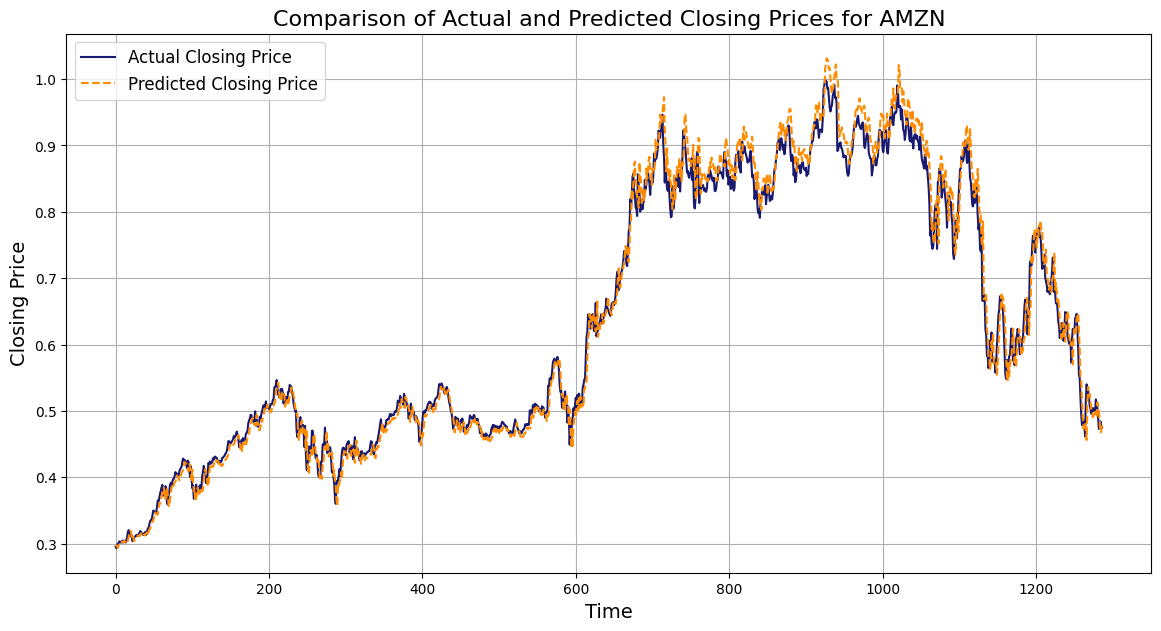

-----Done-----


In [4]:
def main():

    print("Recurrent Neural Network Start")
    data_loader = DataLoader('https://raw.githubusercontent.com/Pravalika05/Stock-Price-Prediction-using-RNN/main/AMZN.csv')
    model = Model()
    model.train_initialize(data_loader, time_step=2)

    print("Training the Model ")
    model.fit()

    print("Predicting the Model")
    model.predict()

    print("-----Done-----")

if __name__ == "__main__":
    main()

In [6]:
from datetime import datetime
now = datetime.now()
print(now)

2023-07-31 00:26:52.820814
